#### 1. Общая информация

Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов: int – полноэкранная реклама; banner – горизонтальный баннер, висит внизу экрана пока юзер играет; rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др.
eCPM – доход за 1000 показов рекламы.

#### 2. Бизнес задача

Провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров. Интересны любые инсайты и находки по eCPM-ам.
Этот csv файл содержит информацию о показах рекламы для юзеров США:
https://drive.google.com/drive/folders/1bjWlzyXV8ALcoxZYrdNQH6_MOm3nS3Pl?us p=sharing
3. Что требуется
1. Для каждого формата рекламы:

a. построить распределение средних eCPM-ов юзеров

b. отобразить средние eCPM-ы по городам, версиям ОС

c. отобразить суммарные доходы по городам, версиям ОС

2. Учесть статистическую значимость для п.1b (отобразить, отфильтровать незначимое или хотя бы прокомментировать). Объяснить решение.
3. Описать наблюдения и вывод по исследованию.


In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Столбец profile_id – id юзера

Столбец event_json содержит данные о событии показа рекламы:

ad_type – формат рекламы (int, banner или rv)

placement – когда/где был показ рекламы в игре

view_index – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)

revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000) 

ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера

network_name – рекламная сеть, от которой был показ

Остальные столбцы должны быть интуитивно понятны


In [38]:
data = pd.read_csv('us_events.csv')
data[:5]

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

In [10]:
data.columns

Index(['profile_id', 'os_version', 'device_manufacturer', 'device_model',
       'device_type', 'device_locale', 'event_name', 'event_json',
       'event_datetime', 'event_timestamp', 'event_receive_datetime',
       'event_receive_timestamp', 'connection_type', 'operator_name',
       'country_iso_code', 'city'],
      dtype='object')

In [26]:
events = data['event_json'].apply(json.loads)
event_data = pd.DataFrame(events.tolist())

In [37]:
event_data.drop(columns=['view_index', 'session_view_index',\
                         'cur_ticks','currency','ad_unit_id',
                        'creativeId', 'ad_network_placement'], axis=1, inplace=True)
event_data[:5]

,ad_type,placement,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,ad_country_code,network_name
0,banner,,705.88070,0.000510,0.487877,0.511508,0.511508,0.000510,US,Google AdMob
1,banner,,722.65120,0.000510,0.488387,0.511389,0.511389,0.000510,US,Google AdMob
2,banner,,431.81290,0.002386,0.678479,0.928597,0.928597,0.002386,US,APPLOVIN_EXCHANGE
3,int,next_level,125.94960,0.013894,0.013894,13.782633,13.893784,0.013894,US,AppLovin
4,banner,,12.71129,0.006828,0.060571,1.660282,1.660282,0.006828,US,Google AdMob


In [42]:
df1 = data[['profile_id', 'event_datetime', 'city', 'os_version']]
final_data=df1.join(event_data, lsuffix="_left", rsuffix="_right")

In [44]:
final_data[:10]

,profile_id,event_datetime,city,os_version,ad_type,placement,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,ad_country_code,network_name
0,JLjpGzDHBQm,2022-02-04 20:02:28,Norwalk,11,banner,,705.88070,0.000510,0.487877,0.511508,0.511508,0.000510,US,Google AdMob
1,JLjpGzDHBQm,2022-02-04 20:02:45,Norwalk,11,banner,,722.65120,0.000510,0.488387,0.511389,0.511389,0.000510,US,Google AdMob
2,JLkVacrzHY6,2022-02-05 17:53:05,Charlotte,11,banner,,431.81290,0.002386,0.678479,0.928597,0.928597,0.002386,US,APPLOVIN_EXCHANGE
3,JMC6wG3cX0f,2022-02-06 17:09:01,Cocoa,10,int,next_level,125.94960,0.013894,0.013894,13.782633,13.893784,0.013894,US,AppLovin
4,JLzWWTJfi1b,2022-02-06 17:15:38,NaN,10,banner,,12.71129,0.006828,0.060571,1.660282,1.660282,0.006828,US,Google AdMob
5,JLzWWTJfi1b,2022-02-06 17:15:53,NaN,10,banner,,27.75300,0.000494,0.061065,1.543673,1.543673,0.000494,US,Google AdMob
6,JLzWWTJfi1b,2022-02-06 17:16:03,NaN,10,banner,,37.62716,0.002386,0.063451,1.627922,1.627922,0.002386,US,APPLOVIN_EXCHANGE
7,JLzWWTJfi1b,2022-02-06 17:16:23,NaN,10,banner,,57.81027,0.000494,0.063945,1.514549,1.514549,0.000494,US,Google AdMob
8,JLzWWTJfi1b,2022-02-06 17:16:33,NaN,10,banner,,67.62502,0.002386,0.066332,1.601711,1.601711,0.002386,US,APPLOVIN_EXCHANGE
9,JLzWWTJfi1b,2022-02-06 17:16:53,NaN,10,banner,,87.80360,0.000494,0.066826,1.490959,1.490959,0.000494,US,Google AdMob


In [78]:
#1a. построить распределение средних eCPM-ов юзеров

avg_ecpm_users = final_data.groupby(['profile_id'])['ecpm_sma'].mean().reset_index()
avg_ecpm_users[:10]

,profile_id,ecpm_sma
0,JL00qCZH1HV,5.379373
1,JL015rw9vmN,2.435747
2,JL01aCdFTJy,1.557256
3,JL04ODuw9UP,2.361296
4,JL06OWhBYxn,0.332892
5,JL06b4k4ygp,0.879389
6,JL06eD8uPpv,2.899562
7,JL09tSq5vCU,1.629271
8,JL0CA7Zu7Tp,0.996885
9,JL0DmG3DU2k,0.744364


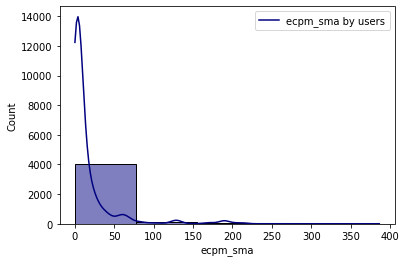

In [80]:
sns.histplot(data = avg_ecpm_users ,x = 'ecpm_sma',\
             color = 'navy', bins = 5, kde = True)

plt.legend(labels=["ecpm_sma by users"])

In [52]:
#1b. отобразить средние eCPM-ы по городам, версиям ОС

avg_ecpm_by_cities_os = final_data.groupby(['city', 'os_version'])['ecpm_sma'].mean().reset_index()
avg_ecpm_by_cities_os[:10]

,city,os_version,ecpm_sma
0,Aberdeen,11,1.390733
1,Abilene,10,44.571796
2,Abilene,11,189.868790
3,Abilene,9,5.850772
4,Addison,12,0.489450
5,Afton,11,2.510671
6,Akron,10,199.292637
7,Akron,12,57.825024
8,Akron,9,6.546945
9,Alameda,12,1.744477


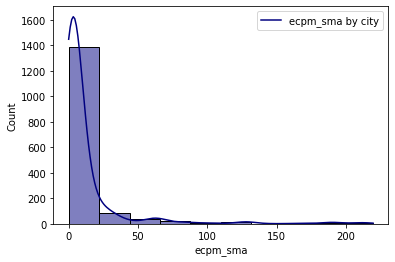

In [75]:
sns.histplot(data = avg_ecpm_by_cities_os ,x = 'ecpm_sma',\
             color = 'navy', bins = 10, kde = True)

plt.legend(labels=["ecpm_sma by city"])

In [81]:
#1c. отобразить суммарные доходы по городам, версиям ОС

avg_revenue_by_cities_os = final_data.groupby(['city', 'os_version'])['revenue'].sum().reset_index()
avg_revenue_by_cities_os[:10]

,city,os_version,revenue
0,Aberdeen,11,0.133882
1,Abilene,10,0.089862
2,Abilene,11,0.191400
3,Abilene,9,0.271433
4,Addison,12,0.000142
5,Afton,11,0.837622
6,Akron,10,0.806200
7,Akron,12,0.116960
8,Akron,9,2.545409
9,Alameda,12,0.211386


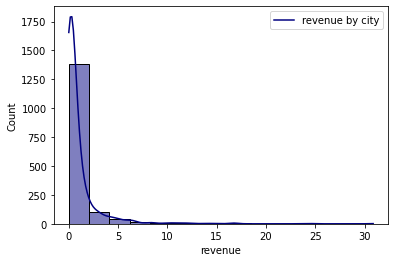

In [85]:
sns.histplot(data = avg_revenue_by_cities_os ,x = 'revenue',\
             color = 'navy', bins = 15, kde = True)

plt.legend(labels=["revenue by city"])

In [87]:
avg_revenue_by_cities_os.describe()

,revenue
count,1566.000000
mean,0.970596
std,2.146506
min,0.000033
25%,0.073077
50%,0.273309
75%,0.908661
max,30.871253


In [95]:
final_data.describe()

,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value
count,860079.000000,860079.000000,860079.000000,860079.000000,860079.000000,860079.000000
mean,5730.505424,0.002780,1.417849,3.147110,3.227661,0.002780
std,15342.189669,0.015129,2.119035,15.973978,16.433888,0.015129
min,2.208125,0.000000,0.000026,0.001014,0.001014,0.000000
25%,512.645300,0.000046,0.268843,0.139942,0.139942,0.000046
50%,1398.315000,0.000494,0.682342,0.480991,0.480991,0.000494
75%,4095.932000,0.000533,1.599739,0.772006,0.772006,0.000533
max,394117.600000,0.937196,26.699762,908.876160,917.695618,0.937196


T-критерий рассчитывается для среднего значения одного набора значений. Нулевая гипотеза состоит в том, что ожидаемое среднее значение выборки независимых наблюдений равно указанному среднему значению генеральной совокупности, popmean.

In [102]:
# perform one sample t-test
t_statistic, p_value = stats.ttest_1samp(a=final_data['ecpm_sma'], popmean=3.15)
print(t_statistic , p_value)

-0.1677647850073831 0.8667683667274636


Поскольку p_value для данной проблемы больше 0,05, что является значением альфа, мы принимаем нулевую гипотезу, а альтернативная гипотеза отклоняется.